In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

# 파일 경로 설정
file_paths_2019 = {
    "01": "상가업소_201906/소상공인시장진흥공단_상가업소정보_201906_01.csv",
    "03": "상가업소_201906/소상공인시장진흥공단_상가업소정보_201906_03.csv",
    "04": "상가업소_201906/소상공인시장진흥공단_상가업소정보_201906_04.csv"
}

# 업종별 대분류 및 중분류 매핑 (2019년 기준)
category_mapping_2019 = {
    "음식": ["음식"],
    "소매": ["소매"],
    "스포츠": ["스포츠", "스포츠/운동"],  # 스포츠와 스포츠/운동 통합
    "오락": ["관광/여가/오락"],  # 관광/여가/오락에서 스포츠/운동 제외
    "숙박": ["숙박"]
}

# 필요한 지역 설정
regions_01 = ['서울특별시', '부산광역시']
regions_03 = ['경기도']
regions_04 = ['제주특별자치도']

# 데이터 병합용 리스트
filtered_data_list_2019 = []

# 01 데이터 처리
data_01 = pd.read_csv(file_paths_2019["01"], encoding="utf-8")
filtered_01 = data_01[data_01["시도명"].isin(regions_01)]
filtered_data_list_2019.append(filtered_01)

# 03 데이터 처리
data_03 = pd.read_csv(file_paths_2019["03"], encoding="utf-8")
filtered_03 = data_03[data_03["시도명"].isin(regions_03)]
filtered_data_list_2019.append(filtered_03)

# 04 데이터 처리
data_04 = pd.read_csv(file_paths_2019["04"], encoding="utf-8")
filtered_04 = data_04[data_04["시도명"].isin(regions_04)]
filtered_data_list_2019.append(filtered_04)

# 모든 데이터를 병합
merged_data_2019 = pd.concat(filtered_data_list_2019, ignore_index=True)

# 대분류와 중분류를 기준으로 분류 추가
def categorize(row):
    # 스포츠 분류: 대분류가 스포츠이거나 중분류가 스포츠/운동 또는 학문/교육 내 학원-예능취미체육인 경우
    if (row["상권업종대분류명"] == "스포츠" or 
        row["상권업종중분류명"] == "스포츠/운동" or 
        (row["상권업종대분류명"] == "학문/교육" and row["상권업종중분류명"] == "학원-예능취미체육")):
        return "스포츠"
    # 오락에서 스포츠/운동 제외한 관광/여가/오락
    elif row["상권업종대분류명"] == "관광/여가/오락" and row["상권업종중분류명"] != "스포츠/운동":
        return "오락"
    # 기타 분류
    for key, values in category_mapping_2019.items():
        if row["상권업종대분류명"] in values:
            return key
    return None

# 분류 추가
merged_data_2019["분류"] = merged_data_2019.apply(categorize, axis=1)

# 유효한 업종만 필터링
merged_data_2019 = merged_data_2019.dropna(subset=["분류"])

# 지역 및 업종별 데이터 집계
region_category_totals_2019 = merged_data_2019.pivot_table(
    index="분류",
    columns="시도명",
    aggfunc="size",
    fill_value=0
)

# 총계 계산
region_category_totals_2019["합계"] = region_category_totals_2019.sum(axis=1)
total_row_2019 = pd.DataFrame(region_category_totals_2019.sum(axis=0)).T
total_row_2019.index = ["합계"]

# 총계 행 추가
region_category_totals_2019 = pd.concat([region_category_totals_2019, total_row_2019])

# 전체 데이터 개수 분의 업종 합계를 계산한 열 추가
total_data_count_2019 = region_category_totals_2019.loc["합계", "합계"]
region_category_totals_2019["비율"] = (region_category_totals_2019["합계"] / total_data_count_2019).round(6)

# 결과 출력
from IPython.display import display
styled_table_2019 = region_category_totals_2019.style.set_properties(**{
    'text-align': 'left',
    'border': '1px solid black',
    'background-color': '#f9f9f9'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

display(styled_table_2019)


시도명,경기도,부산광역시,서울특별시,제주특별자치도,합계,비율
소매,205799,52808,124782,13307,396696,0.459824
숙박,6385,2193,3047,2826,14451,0.016751
스포츠,4362,790,1846,286,7284,0.008443
오락,19123,4685,11545,893,36246,0.042014
음식,206724,52028,131687,17596,408035,0.472968
합계,442393,112504,272907,34908,862712,1.000000


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

# 파일 경로 설정
file_paths_2023 = {
    "경기": "소상공인시장진흥공단_상가(상권)정보_경기_202306.csv",
    "부산": "소상공인시장진흥공단_상가(상권)정보_부산_202306.csv",
    "서울": "소상공인시장진흥공단_상가(상권)정보_서울_202306.csv",
    "제주": "소상공인시장진흥공단_상가(상권)정보_제주_202306.csv"
}

# 업종별 대분류 및 중분류 매핑 (2023년 기준)
category_mapping_2023 = {
    "음식": ["음식"],
    "소매": ["소매"],
    "스포츠": ["스포츠 서비스"],
    "오락": ["유원지·오락"],
    "숙박": ["숙박"]
}

# 데이터 병합용 리스트
filtered_data_list_2023 = []

# 파일별 데이터 처리
for region, path in file_paths_2023.items():
    data = pd.read_csv(path, encoding="utf-8")
    
    # 예술·스포츠 대분류 처리
    data["분류"] = data.apply(
        lambda row: next((key for key, values in category_mapping_2023.items()
                          if row["상권업종대분류명"] == "예술·스포츠" and row["상권업종중분류명"] in values), None)
        if row["상권업종대분류명"] == "예술·스포츠"
        else next((key for key, values in category_mapping_2023.items()
                   if row["상권업종대분류명"] in values), None),
        axis=1
    )
    
    # 유효한 업종만 필터링
    filtered_data = data.dropna(subset=["분류"])
    filtered_data_list_2023.append(filtered_data)

# 모든 데이터를 병합
merged_data_2023 = pd.concat(filtered_data_list_2023, ignore_index=True)

# 지역 및 업종별 데이터 집계
region_category_totals_2023 = merged_data_2023.pivot_table(
    index="분류",
    columns="시도명",
    aggfunc="size",
    fill_value=0
)

# 총계 계산
region_category_totals_2023["합계"] = region_category_totals_2023.sum(axis=1)
total_row_2023 = pd.DataFrame(region_category_totals_2023.sum(axis=0)).T
total_row_2023.index = ["합계"]

# 총계 행 추가
region_category_totals_2023 = pd.concat([region_category_totals_2023, total_row_2023])

# 전체 데이터 개수 분의 업종 합계를 계산한 열 추가
total_data_count = region_category_totals_2023.loc["합계", "합계"]
region_category_totals_2023["비율"] = (region_category_totals_2023["합계"] / total_data_count).round(6)


# 결과 출력
from IPython.display import display
styled_table_2023 = region_category_totals_2023.style.set_properties(**{
    'text-align': 'left',
    'border': '1px solid black',
    'background-color': '#f9f9f9'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

display(styled_table_2023)


시도명,경기도,부산광역시,서울특별시,제주특별자치도,합계,비율
소매,138314,39398,105840,11956,295508,0.386969
숙박,9439,2293,6439,6751,24922,0.032635
스포츠,11373,2501,7881,794,22549,0.029528
오락,13944,2850,9724,983,27501,0.036013
음식,178492,54993,140057,19625,393167,0.514854
합계,351562,102035,269941,40109,763647,1.000000


In [4]:
import pandas as pd

# 2019 데이터
data_2019 = {
    "업종": ["소매", "숙박", "스포츠", "오락", "음식", "합계"],
    "합계": [396696, 14451, 7284, 36246, 408035, 862712]
}

# 2023 데이터
data_2023 = {
    "업종": ["소매", "숙박", "스포츠", "오락", "음식", "합계"],
    "합계": [295508, 24922, 22549, 27501, 393167, 763647]
}

# 데이터프레임 생성
df_2019 = pd.DataFrame(data_2019).set_index("업종")
df_2023 = pd.DataFrame(data_2023).set_index("업종")

# 변화율 계산
change_rate = ((df_2023["합계"] - df_2019["합계"]) / df_2019["합계"] * 100).round(2)

# 회복률 계산
recovery_rate = (df_2023["합계"] / df_2019["합계"] * 100).round(2)

# 결과 데이터프레임 생성
change_rate_df = pd.DataFrame({
    "업종": df_2019.index,
    "2019 합계": df_2019["합계"],
    "2023 합계": df_2023["합계"],
    "변화율 (%)": change_rate,
    "회복률 (%)": recovery_rate
}).reset_index(drop=True)

# 스타일링 및 출력
styled_change_rate_df = change_rate_df.style.set_properties(**{
    'text-align': 'left',
    'border': '1px solid black',
    'background-color': '#f9f9f9'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

from IPython.display import display
display(styled_change_rate_df)


,업종,2019 합계,2023 합계,변화율 (%),회복률 (%)
0,소매,396696,295508,-25.510000,74.490000
1,숙박,14451,24922,72.460000,172.460000
2,스포츠,7284,22549,209.570000,309.570000
3,오락,36246,27501,-24.130000,75.870000
4,음식,408035,393167,-3.640000,96.360000
5,합계,862712,763647,-11.480000,88.520000


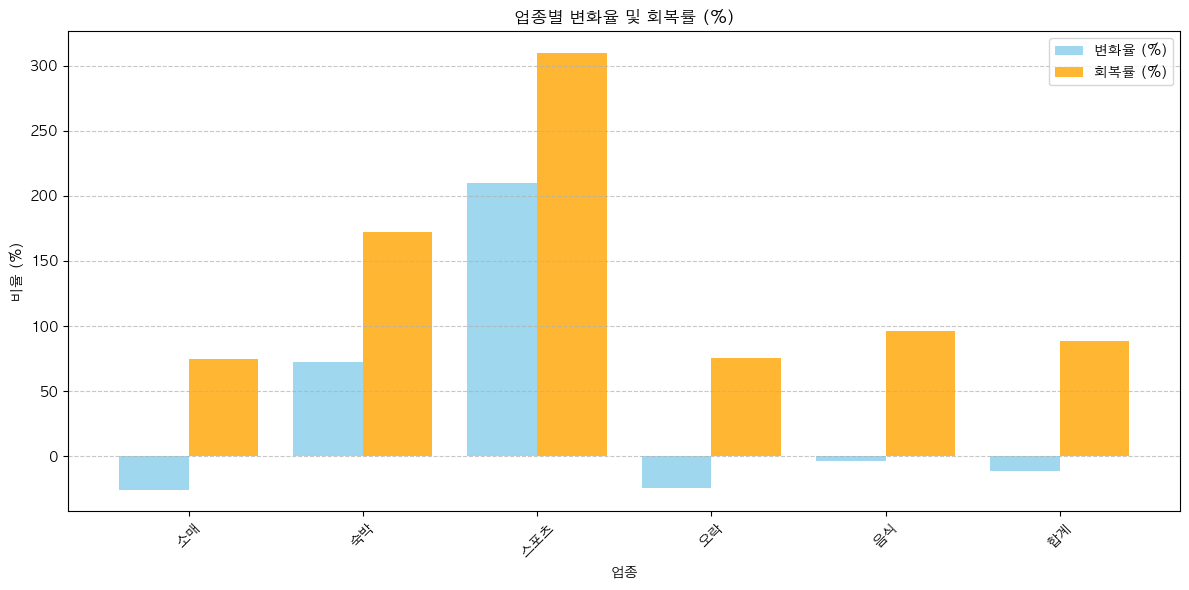

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if platform.system() == "Darwin":  # macOS
    plt.rc("font", family="AppleGothic")

plt.rcParams["axes.unicode_minus"] = False  # 마이너스(-) 기호가 깨지는 문제 해결

# 데이터 준비
data_2019 = {
    "업종": ["소매", "숙박", "스포츠", "오락", "음식", "합계"],
    "합계": [396696, 14451, 7284, 36246, 408035, 862712]
}

data_2023 = {
    "업종": ["소매", "숙박", "스포츠", "오락", "음식", "합계"],
    "합계": [295508, 24922, 22549, 27501, 393167, 763647]
}

df_2019 = pd.DataFrame(data_2019).set_index("업종")
df_2023 = pd.DataFrame(data_2023).set_index("업종")

# 변화율 및 회복률 계산
change_rate = ((df_2023["합계"] - df_2019["합계"]) / df_2019["합계"] * 100).round(2)
recovery_rate = (df_2023["합계"] / df_2019["합계"] * 100).round(2)

# 데이터프레임 생성
change_rate_df = pd.DataFrame({
    "업종": df_2019.index,
    "변화율 (%)": change_rate,
    "회복률 (%)": recovery_rate
}).reset_index(drop=True)
change_rate_df.set_index("업종", inplace=True)

# 시각화 - 변화율 및 회복률
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(change_rate_df))

# 변화율
plt.bar(index, change_rate_df["변화율 (%)"], bar_width, label="변화율 (%)", color="skyblue", alpha=0.8)

# 회복률
plt.bar(
    [i + bar_width for i in index],
    change_rate_df["회복률 (%)"],
    bar_width,
    label="회복률 (%)",
    color="orange",
    alpha=0.8,
)

# 그래프 설정
plt.title("업종별 변화율 및 회복률 (%)")
plt.ylabel("비율 (%)")
plt.xlabel("업종")
plt.xticks([i + bar_width / 2 for i in index], change_rate_df.index, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
from IPython.display import display

# 데이터 준비
region_data_2019 = {
    "지역": ["경기도", "부산광역시", "서울특별시", "제주특별자치도"],
    "합계": [442393, 112504, 272907, 34908]
}

region_data_2023 = {
    "지역": ["경기도", "부산광역시", "서울특별시", "제주특별자치도"],
    "합계": [351562, 102035, 269941, 40109]
}

# 데이터프레임 생성
df_2019 = pd.DataFrame(region_data_2019)
df_2023 = pd.DataFrame(region_data_2023)

# 변화율 계산
change_rate = ((df_2023["합계"] - df_2019["합계"]) / df_2019["합계"] * 100).round(2)

# 회복률 계산
recovery_rate = (df_2023["합계"] / df_2019["합계"] * 100).round(2)

# 데이터프레임 생성
df_analysis = pd.DataFrame({
    "지역": df_2019["지역"],
    "2019 합계": df_2019["합계"],
    "2023 합계": df_2023["합계"],
    "변화율 (%)": change_rate,
    "회복률 (%)": recovery_rate
})

# 결과 출력
styled_df_analysis = df_analysis.style.set_properties(**{
    'text-align': 'left',
    'border': '1px solid black',
    'background-color': '#f9f9f9'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

print("\n지역별 변화율 및 회복률 분석:")
display(styled_df_analysis)



지역별 변화율 및 회복률 분석:


,지역,2019 합계,2023 합계,변화율 (%),회복률 (%)
0,경기도,442393,351562,-20.530000,79.470000
1,부산광역시,112504,102035,-9.310000,90.690000
2,서울특별시,272907,269941,-1.090000,98.910000
3,제주특별자치도,34908,40109,14.900000,114.900000


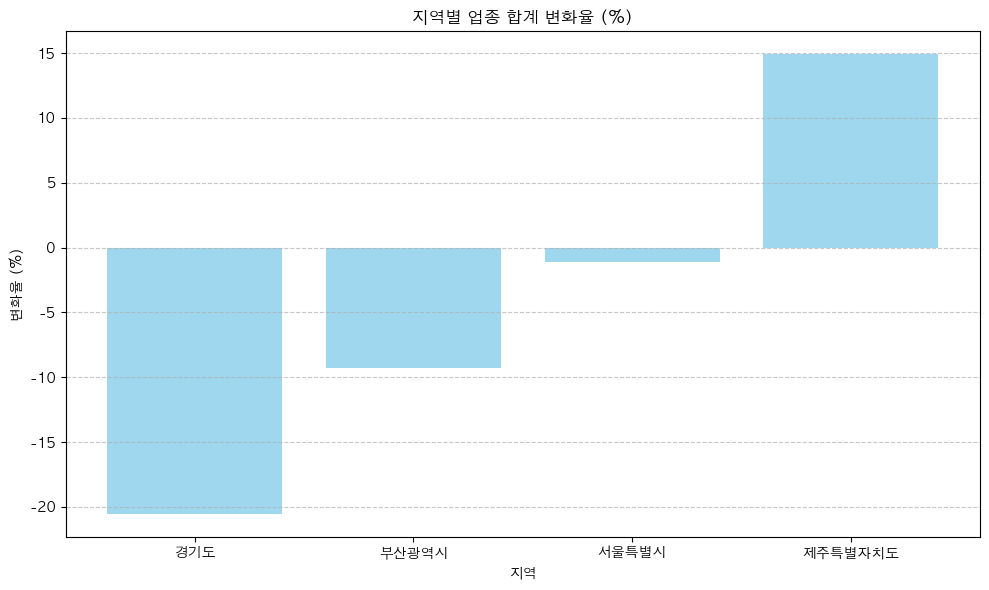

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df_analysis["지역"], df_analysis["변화율 (%)"], color="skyblue", alpha=0.8)
plt.title("지역별 업종 합계 변화율 (%)")
plt.xlabel("지역")
plt.ylabel("변화율 (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


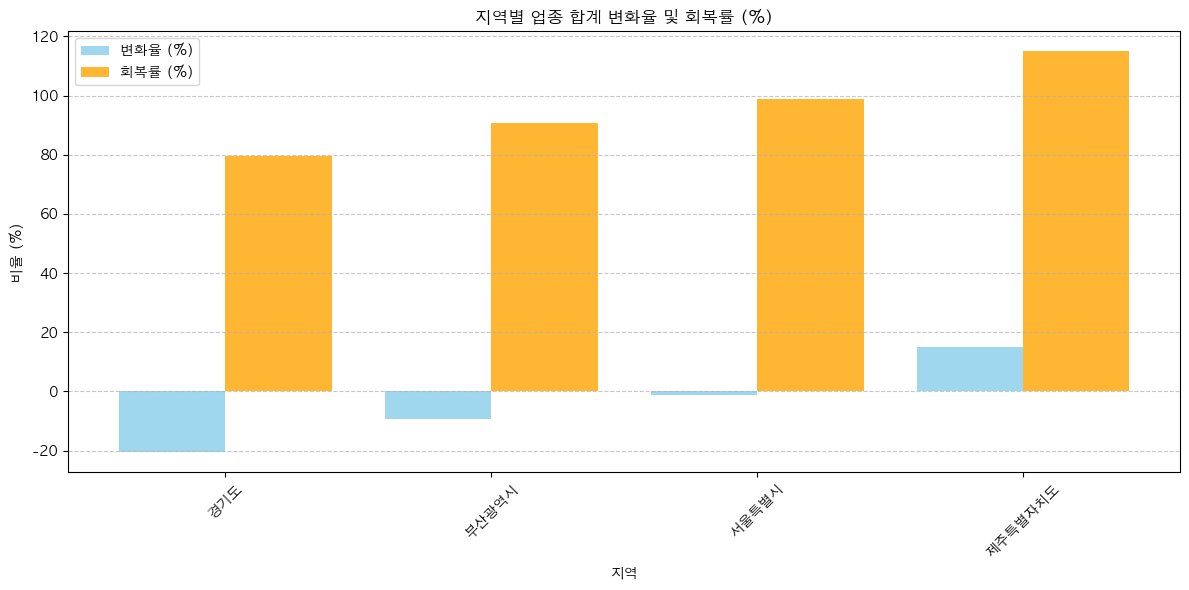

In [11]:
# 시각화
# 막대 폭 설정
bar_width = 0.4

# X축 인덱스 생성
x_indexes = np.arange(len(df_analysis["지역"]))

plt.figure(figsize=(12, 6))

# 변화율 막대
plt.bar(
    x_indexes, 
    df_analysis["변화율 (%)"], 
    width=bar_width, 
    color="skyblue", 
    alpha=0.8, 
    label="변화율 (%)"
)

# 회복률 막대
plt.bar(
    x_indexes + bar_width, 
    df_analysis["회복률 (%)"], 
    width=bar_width, 
    color="orange", 
    alpha=0.8, 
    label="회복률 (%)"
)

# 그래프 제목 및 레이블 설정
plt.title("지역별 업종 합계 변화율 및 회복률 (%)")
plt.xlabel("지역")
plt.ylabel("비율 (%)")
plt.xticks(ticks=x_indexes + bar_width / 2, labels=df_analysis["지역"], rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 그래프 출력
plt.tight_layout()
plt.show()

In [2]:
from scipy.stats import ttest_1samp
import pandas as pd
from IPython.display import display

# 데이터 준비
data_2019 = {
    "업종": ["소매", "숙박", "스포츠", "오락", "음식"],
    "경기도": [205799, 6385, 4362, 19123, 206724],
    "부산광역시": [52808, 2193, 790, 4685, 52028],
    "서울특별시": [124782, 3047, 1846, 11545, 131687],
    "제주특별자치도": [13307, 2826, 286, 893, 17596],
}

data_2023 = {
    "업종": ["소매", "숙박", "스포츠", "오락", "음식"],
    "경기도": [138314, 9439, 11373, 13944, 178492],
    "부산광역시": [39398, 2293, 2501, 2850, 54993],
    "서울특별시": [105840, 6439, 7881, 9724, 140057],
    "제주특별자치도": [11956, 6751, 794, 983, 19625],
}

# 데이터프레임 생성
df_2019 = pd.DataFrame(data_2019).set_index("업종")
df_2023 = pd.DataFrame(data_2023).set_index("업종")

# 회복률 계산
recovery_rate = (df_2023 / df_2019 * 100).round(2)

# 기준값 설정 (85%)
benchmark = 85

# 업종별 T-검정 수행
t_test_results_by_industry = []
for industry, row in recovery_rate.iterrows():
    numeric_data = row.astype(float)
    t_stat, p_value = ttest_1samp(numeric_data, benchmark)
    p_value_one_tailed = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
    t_test_results_by_industry.append({
        "업종": industry,
        "T-통계량": round(t_stat, 4),
        "p-value (단측)": round(p_value_one_tailed, 6),
        "검정결과": "귀무가설 기각 (평균 회복률이 85%보다 큼)" if p_value_one_tailed < 0.05 else "귀무가설 채택 (평균 회복률이 85%보다 크다고 볼 수 없음)"
    })

# 지역별 T-검정 수행
t_test_results_by_region = []
for region in df_2019.columns:  # 지역별로 반복
    t_stat, p_value = ttest_1samp(recovery_rate[region], benchmark)
    p_value_one_tailed = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
    t_test_results_by_region.append({
        "지역": region,
        "T-통계량": round(t_stat, 4),
        "p-value (단측)": round(p_value_one_tailed, 6),
        "검정결과": "귀무가설 기각 (회복률이 85%보다 큼)" if p_value_one_tailed < 0.05 else "귀무가설 채택 (회복률이 85%보다 크다고 볼 수 없음)"
    })

# 결과 데이터프레임 생성
df_t_test_results_industry = pd.DataFrame(t_test_results_by_industry)
df_t_test_results_region = pd.DataFrame(t_test_results_by_region)

# 결과 출력 - 업종별
print("\n업종별 회복률 T-검정 결과:")
display(df_t_test_results_industry.style.set_properties(**{
    'text-align': 'left',
    'border': '1px solid black',
    'background-color': '#f9f9f9'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}]))

# 결과 출력 - 지역별
print("\n지역별 회복률 T-검정 결과:")
display(df_t_test_results_region.style.set_properties(**{
    'text-align': 'left',
    'border': '1px solid black',
    'background-color': '#f9f9f9'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}]))



업종별 회복률 T-검정 결과:


,업종,T-통계량,p-value (단측),검정결과
0,소매,-1.156700,0.834438,귀무가설 채택 (평균 회복률이 85%보다 크다고 볼 수 없음)
1,숙박,2.980600,0.029284,귀무가설 기각 (평균 회복률이 85%보다 큼)
2,스포츠,6.302100,0.004036,귀무가설 기각 (평균 회복률이 85%보다 큼)
3,오락,-0.284200,0.602618,귀무가설 채택 (평균 회복률이 85%보다 크다고 볼 수 없음)
4,음식,3.157700,0.025480,귀무가설 기각 (평균 회복률이 85%보다 큼)



지역별 회복률 T-검정 결과:


,지역,T-통계량,p-value (단측),검정결과
0,경기도,1.154600,0.156261,귀무가설 채택 (회복률이 85%보다 크다고 볼 수 없음)
1,부산광역시,1.013200,0.184127,귀무가설 채택 (회복률이 85%보다 크다고 볼 수 없음)
2,서울특별시,1.494100,0.104723,귀무가설 채택 (회복률이 85%보다 크다고 볼 수 없음)
3,제주특별자치도,2.092700,0.052257,귀무가설 채택 (회복률이 85%보다 크다고 볼 수 없음)


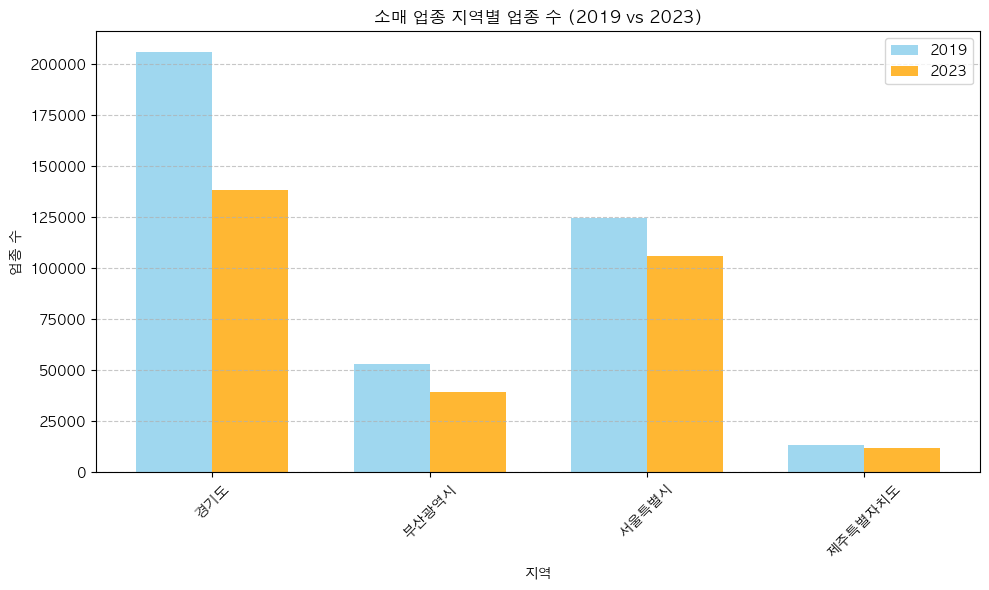

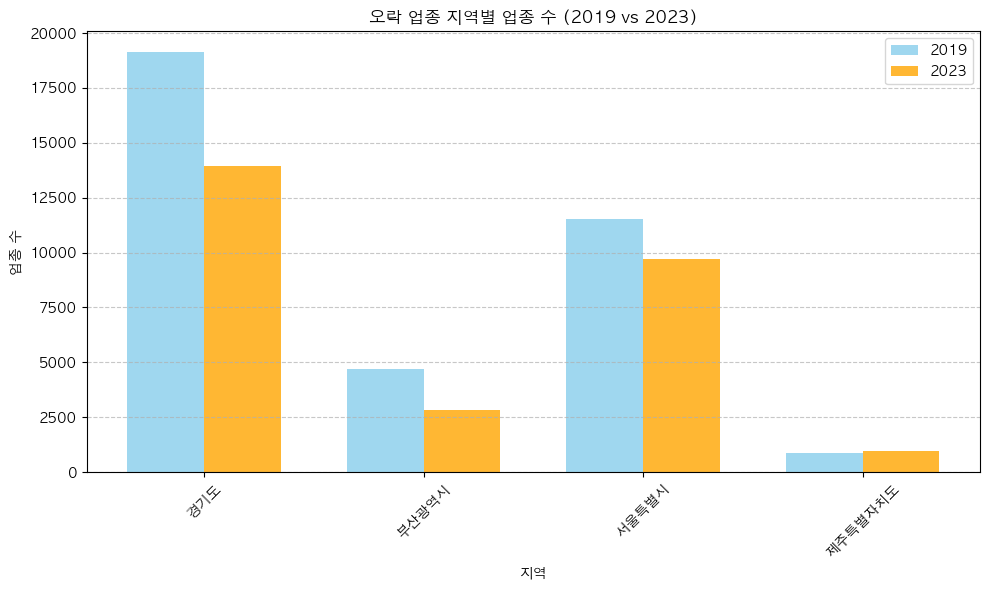

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
selected_industries = ["소매", "오락"]
filtered_2019 = df_2019.loc[selected_industries]
filtered_2023 = df_2023.loc[selected_industries]

# 한글 폰트 설정 (Mac OS 기준)
plt.rc("font", family="AppleGothic")
plt.rcParams["axes.unicode_minus"] = False  # 마이너스(-) 기호 깨짐 방지

# 소매 데이터 시각화
regions = filtered_2019.columns
x = np.arange(len(regions))  # X축 위치
width = 0.35  # 막대 너비

plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, filtered_2019.loc["소매"], width, label="2019", alpha=0.8, color="skyblue")
plt.bar(x + width / 2, filtered_2023.loc["소매"], width, label="2023", alpha=0.8, color="orange")
plt.title("소매 업종 지역별 업종 수 (2019 vs 2023)")
plt.xlabel("지역")
plt.ylabel("업종 수")
plt.xticks(x, regions, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 오락 데이터 시각화
plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, filtered_2019.loc["오락"], width, label="2019", alpha=0.8, color="skyblue")
plt.bar(x + width / 2, filtered_2023.loc["오락"], width, label="2023", alpha=0.8, color="orange")
plt.title("오락 업종 지역별 업종 수 (2019 vs 2023)")
plt.xlabel("지역")
plt.ylabel("업종 수")
plt.xticks(x, regions, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
